In [1]:
import numpy as np
from scipy.special import binom
from numpy.linalg import cond

import matplotlib.pyplot as plt
from pylab import rcParams
import imageio
from sklearn.metrics import mean_squared_error as mse

## 1. Постановка задачи

Будем строить интерполяцию для функции Рунге

$$f (x) = \frac{1}{1 + 25x^2}$$

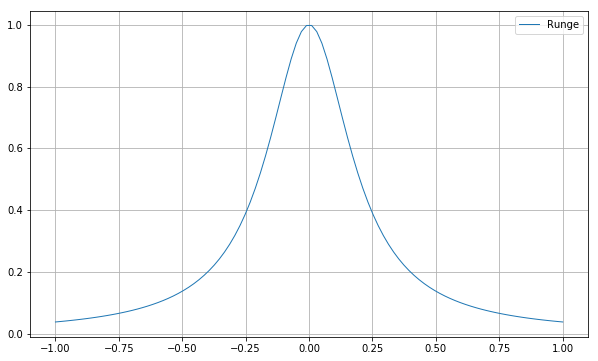

In [2]:
x = np.linspace(-1, 1, 100)

def runge(x):
    return (x**2 * 25 + 1) ** -1

y = runge(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, lw=1, label='Runge')
plt.grid()
plt.legend();

## 2. Алгебраическая интерполяция (форма Лагранжа)

$$P_n(x) = f(x_0)\ell_0(x) + f(x_1)\ell_1(x)+\dots+f(x_n)\ell_n(x),$$

$$\text{где }\ell_k(x) = \dfrac{(x - x_0)\dots(x - x_{k-1})(x - x_{k+1})\dots(x - x_n)}{(x_k - x_0)\dots(x_k - x_{k-1})(x_k - x_{k+1})\dots(x_k-x_n)}$$

In [3]:
def lagr_poly(x, degree=10, nodes='uniform', function=runge):
    if nodes == 'uniform':
        t = np.linspace(-1, 1, degree)
    elif nodes == 'chebyshev':
        k = np.arange(1., degree+1)
        t = np.cos((2*k - 1) * np.pi / (2*degree))[::-1]
    else:
        print("Doesn't have such nodes type: {}".format(nodes))
        
    l_coefs = []
    for i in range(len(t)):
        l_coef = np.polynomial.polynomial.polyfromroots(np.delete(t,i))
        coef = 1
        for j in range(len(t)):
            if (j != i):
                coef = coef * (t[i] - t[j])
        l_coef /=  coef
        l_coefs.append(l_coef * function(t[i]))

    lagrangian_coefs = np.zeros(degree)
    for i in range(len(l_coefs)):
        lagrangian_coefs = lagrangian_coefs + l_coefs[i]
        
    lagr_f = np.poly1d(lagrangian_coefs[::-1])
    
    return lagr_f(x)

### 2.1 Равномерная сетка

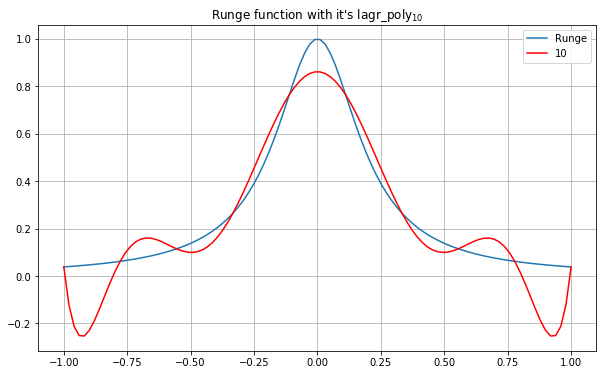

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(x, runge(x), '-', label='Runge')
plt.plot(x, lagr_poly(x, 10), 'r-', label=10)
plt.title("Runge function with it's lagr_poly$_{10}$")
plt.grid()
plt.legend();

In [7]:
print('MSE = %0.7f' % mse(runge(x), lagr_poly(x, 10)))

MSE = 0.0118887


Построим gif-изображение из интерполяций на разном количестве узлов. Так будет проще увидеть тенденцию.

In [6]:
def plot_for_offset(n, y_max):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, runge(x), '-', label='Runge')
    ax.plot(x, lagr_poly(x, n), 'r-', label='{}'.format(n))
    ax.grid()
    ax.legend()

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('img/runge_uniform_interpolation.gif', 
                [plot_for_offset(i, 100) for i in [3, 5, 8, 10, 12, 15, 20, 25]], fps=1)

Видно, что при увеличении числа узлов, интерполянты начинают сильно осциллировать на концах (так называемый "феномен Рунге").

<img src=img/runge_uniform_interpolation.gif>

Посмотрим, насколько возможно уменьшить ошибку интерполяции только за счёт выбора узлов $x_k$. 

### 2.2 Сетка из нулей полинома Чебышёва

При использовании узлов Чебышёва

$$\displaystyle \left|f(x)-P_{n-1}(x)\right|\leq {\frac {1}{2^{n-1}}}\left({\frac {b-a}{2}}\right)^{n}\max _{\xi \in [a,b]}\left|f^{(n)}(\xi )\right|={\frac {1}{2^{2n-1}}}h^nn^{n}\approx {\frac {h^nn!n^{n}}{2^{2n-1}\sqrt{2\pi n}}} = h^nn!\left(\frac{e}{4}\right)^n\sqrt{\frac{2}{\pi n}}$$

Существенное отличие от равномерной сетки в быстро убывающем при $n\rightarrow \infty$ сомножителе $\left(\frac{e}{4}\right)^n$

Узлы можно найти, используя следующую формулу
$$t_k = \cos\left(\frac{2k-1}{2n}\pi\right), \;\;\;k \in \{1, \dots 10\}$$

Например для 25 узлов

In [8]:
n = 25
k = np.arange(1, n+1)

t = np.cos((2*k - 1) * np.pi / (2*n))[::-1]
print('Узлы интерполяции:\n',  np.round(t, 4))

Узлы интерполяции:
 [-0.998  -0.9823 -0.9511 -0.9048 -0.8443 -0.7705 -0.6845 -0.5878 -0.4818
 -0.3681 -0.2487 -0.1253  0.      0.1253  0.2487  0.3681  0.4818  0.5878
  0.6845  0.7705  0.8443  0.9048  0.9511  0.9823  0.998 ]


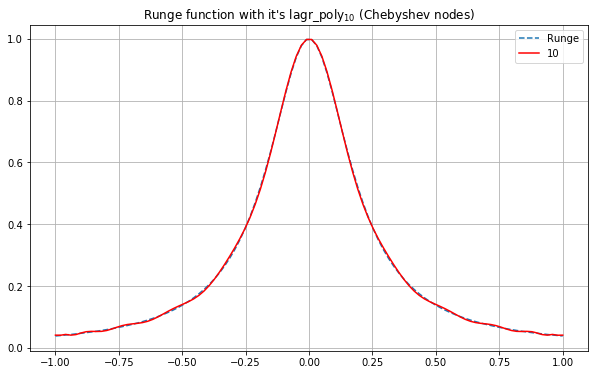

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x, runge(x), '--', label='Runge')
plt.plot(x, lagr_poly(x, 25, nodes='chebyshev'), 'r-', label='10')
plt.title("Runge function with it's lagr_poly$_{10}$ (Chebyshev nodes)")
plt.grid()
plt.legend();

In [10]:
print('MSE = %0.7f' % mse(runge(x), lagr_poly(x, 25, nodes='chebyshev')))

MSE = 0.0000114


Снова построим gif для наглядности

In [11]:
def plot_for_offset(n, y_max):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, runge(x), '-', label='Runge')
    ax.plot(x, lagr_poly(x, n, nodes='chebyshev'), 'r-', label='{}'.format(n))
    ax.grid()
    ax.legend()

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('img/runge_chebyshev_interpolation.gif', 
                [plot_for_offset(i, 100) for i in [3, 5, 8, 10, 12, 15, 20, 25]], fps=1)

Как говорится в одном рекламном ролике, почувствуйте разницу

<img src=img/runge_chebyshev_interpolation.gif>

## 3. Кусочно-многочленная интерполяция. Сплайны

Глобальная алгебраическая интерполяция при большом количестве узлов начинают
испытывать проблемы при быстром росте констант $M_n$ (максимального значения $f^{(n)}(x)$) и весьма чувствительна к
заданию функции в узлах.
Одно из решений  проводить не глобальную, а локальную интерполяцию, по
небольшому количеству соседних узлов. Такой интерполянт называется сплайном.

Далее рассмотрим естественный кубический сплайн (поскольку он наиболее широко распространнён на практике в случае необходимости гладкой интерполяции).

Кубический сплайн состоит из кусков вида $P_i(x) = a_i + b_i (x-x_i) + c_i(x-x_i)^2 + d_i (x-x_i)^3$.

В поставленой задачи задано $k+1$ точек $(x_0, y_0), \dots (x_k, y_k)$, мы ищем $k$ полиномов $P_i(x)$, которые удовлетворяеют для $1 \le i \le k-1$ условиям:

$P_0(x_0) = y_0$ и $P_{i-1}(x_i) = y_i = P_i(x_i)$

$P'_{i-1}(x_i) = P'_i(x_i)$

$P''_{i-1}(x_i) = P''_i(x_i)$

$P''_0(x_0) = P''_{k-1}(x_k)$

Такие полиномы $P_i$ задаются пятеркой $(a, b, c, d, x)$, где $a$, $b$, $c$, $d$ - коэффициенты многочлена, а $x$ соответствует области определения полинома $[x_i, x_{i+1}]$.

In [12]:
def cubic_spline(x, y):
    k = len(x) - 1
    a = y.copy()
    b, d, mu = np.zeros(k), np.zeros(k), np.zeros(k)
    c, l, z = np.zeros(k+1), np.zeros(k+1), np.zeros(k+1)
    
    h = [x[i+1] - x[i] for i in range(k)]
    alpha = [3 / h[i] * (a[i+1] - a[i]) - 3 / h[i-1] * (a[i] - a[i-1]) for i in range(k-1)]
    l[0] = 1
    
    for i in range(1, k-1):
        l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * mu[i-1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]
    l[k] = 1

    for j in range(k-1, -1, -1):
        c[j] = z[j] - mu[j] * c[j+1]
        b[j] = (a[j+1] - a[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j])/3
        d[j] = (c[j+1] - c[j]) / (3 * h[j])
    
    params = [[a[i], b[i], c[i], d[i], x[i]] for i in range(k)]
    return np.array(params)

In [13]:
def P(x0, params):
    i = np.max([i for i in range(len(params)) if params[i][4] <= x0])
    a, b, c, d, x_ = params[i]
    func = np.poly1d([d, c, b, a])
    return func(x0 - x_)

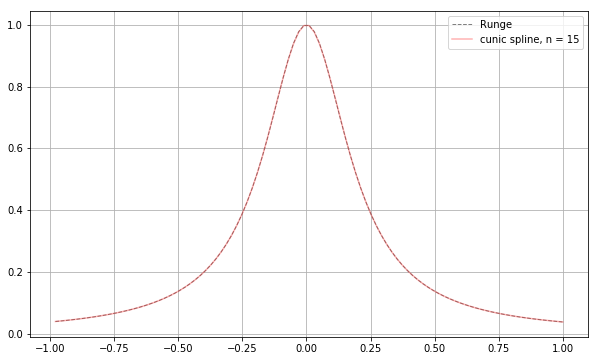

In [14]:
t = np.linspace(-1, 1, 25)
params = cubic_spline(t, runge(t))
spline_vals = [P(x, params) for x in x[1:]]

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(x[1:], runge(x[1:]), '--', color='gray', lw=1, label='Runge');
plt.plot(x[1:], spline_vals, color='r', alpha=.3, label='cunic spline, n = 15');
plt.legend();

In [15]:
print('MSE = %0.7f' % mse(runge(x[1:]), spline_vals))

MSE = 0.0000003


В очередной раз построим gif

In [16]:
def plot_for_offset(n, y_max):
    fig, ax = plt.subplots(figsize=(10,6))
    t = np.linspace(-1, 1, n)
    params = cubic_spline(t, runge(t))
    spline_vals = [P(x, params) for x in x[1:]]
    ax.plot(x[1:], runge(x[1:]), '-', label='Runge')
    ax.plot(x[1:], spline_vals, 'r-', label='{}'.format(n))
    ax.grid()
    ax.legend()

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('img/spline_interpolation.gif', 
#                 [plot_for_offset(i, 100) for i in np.arange(2, 30, 2)], fps=1)

<img src=img/spline_interpolation.gif>

При повышении числа узлов качество остаётся примерно на том же уровне.

## 4. Выводы

- Алгебраическая интерполяция чувствительна к выбору узлов (это видно из "феномена Рунге"). Гарантированно хороший результат (погрешность равномерно стремится к 0 при условии существования хотя бы 2-ой производной) дают нули полинома Чебышёва.
- Сплайны - пример локальной интерполяции. Они зависят скорее от количества узлов, чем от их типа. В целом они позволили добиться наиболее высокой точности, что согласуется с их распространением на практике.